In [1]:
import sys
import pickle
from pathlib import Path

package_path = str(Path.cwd().parent)
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, sem

import deepchem as dc
from rdkit.rdBase import BlockLogs
from sklearn.manifold import TSNE
from tbprop.tree_based.features import morgan_fingerprint

from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/Users/vedang/miniconda3/envs/metal2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Users/vedang/miniconda3/envs/metal2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


### Load Datasets

In [2]:
pk_trn = pd.read_csv("../data/pk/pk_trn.csv")[['smiles', 'auc_bin']]
pk_val = pd.read_csv("../data/pk/pk_val.csv")[['smiles', 'auc_bin']]
pk_tst = pd.read_csv("../data/pk/pk_tst.csv")[['smiles', 'auc_bin']]

pk_trn['split'] = 0
pk_val['split'] = 1
pk_tst['split'] = 2

pk = pd.concat([pk_trn, pk_val, pk_tst])

In [3]:
taacf_trn = pd.read_csv("../data/taacf/taacf_trn.csv")[['smiles', 'inhibition_bin']]
taacf_val = pd.read_csv("../data/taacf/taacf_val.csv")[['smiles', 'inhibition_bin']]
taacf_tst = pd.read_csv("../data/taacf/taacf_tst.csv")[['smiles', 'inhibition_bin']]

taacf_trn['split'] = 0
taacf_val['split'] = 1
taacf_tst['split'] = 2

taacf = pd.concat([taacf_trn, taacf_val, taacf_tst])

In [4]:
mlsmr_trn = pd.read_csv("../data/mlsmr/mlsmr_trn.csv")[['smiles', 'inhibition_bin']]
mlsmr_val = pd.read_csv("../data/mlsmr/mlsmr_val.csv")[['smiles', 'inhibition_bin']]
mlsmr_tst = pd.read_csv("../data/mlsmr/mlsmr_tst.csv")[['smiles', 'inhibition_bin']]

mlsmr_trn['split'] = 0
mlsmr_val['split'] = 1
mlsmr_tst['split'] = 2

mlsmr = pd.concat([mlsmr_trn, mlsmr_val, mlsmr_tst])

In [5]:
print(f"Shape of PK dataset = {pk.shape}")
print(f"Shape of TAACF dataset = {taacf.shape}")
print(f"Shape of MLSMR dataset = {mlsmr.shape}")

Shape of PK dataset = (190, 3)
Shape of TAACF dataset = (124094, 3)
Shape of MLSMR dataset = (214506, 3)


In [48]:
del mlsmr_trn, mlsmr_val, mlsmr_tst, taacf_trn, taacf_val, taacf_tst, pk_trn, pk_val, pk_tst

In [49]:
pk.rename({'auc_bin': 'y'}, axis=1, inplace=True)
taacf.rename({'inhibition_bin': 'y'}, axis=1, inplace=True)
mlsmr.rename({'inhibition_bin': 'y'}, axis=1, inplace=True)

for df in [pk, taacf, mlsmr]:
    df['y'] = df['y'].astype(int)

In [50]:
enamine_top = pd.read_csv("../data/enamine_hts/top956.csv")[['SMILES']]
enamine_top.rename({'SMILES': 'smiles'}, axis=1, inplace=True)
enamine_top['split'] = 4

In [51]:
pk.reset_index(inplace=True, drop=True)
taacf.reset_index(inplace=True, drop=True)
mlsmr.reset_index(inplace=True, drop=True)
enamine_top.reset_index(inplace=True, drop=True)

### Analysis

In [52]:
pk = morgan_fingerprint(pk, smiles_col='smiles', n_bits=1024)
print("Finished PK.")
taacf = morgan_fingerprint(taacf, smiles_col='smiles', n_bits=1024)
print("Finished TAACF.")
mlsmr = morgan_fingerprint(mlsmr, smiles_col='smiles', n_bits=1024)
print("Finished MLSMR.")
enamine_top = morgan_fingerprint(enamine_top, smiles_col='smiles', n_bits=1024)
print("Finished Enamine top hits.")
print("Done.")

Finished PK.
Finished TAACF.
Finished MLSMR.
Finished Enamine top hits.
Done.


In [53]:
pk.to_csv("../data/archive/pk_mfp.csv", index=False)
taacf.to_csv("../data/archive/taacf_mfp.csv", index=False)
mlsmr.to_csv("../data/archive/mlsmr_mfp.csv", index=False)
enamine_top.to_csv("../data/archive/enamine_mfp.csv", index=False)

In [3]:
pk = pd.read_csv("../data/archive/pk_mfp.csv")
taacf = pd.read_csv("../data/archive/taacf_mfp.csv")
mlsmr = pd.read_csv("../data/archive/mlsmr_mfp.csv")
enamine_top = pd.read_csv("../data/archive/enamine_mfp.csv")

In [36]:
top96 = pd.read_csv("../data/enamine_hts/top96.csv")

In [40]:
enamine_top['selected'] = enamine_top['smiles'].apply(lambda x: x in top96['SMILES'].values)
enamine_top['split'] = enamine_top['selected'].apply(lambda x: 5 if x else 4)

Processing PK dataset...Done.
Processing TAACF dataset...Done.
Processing MLSMR dataset...Done.


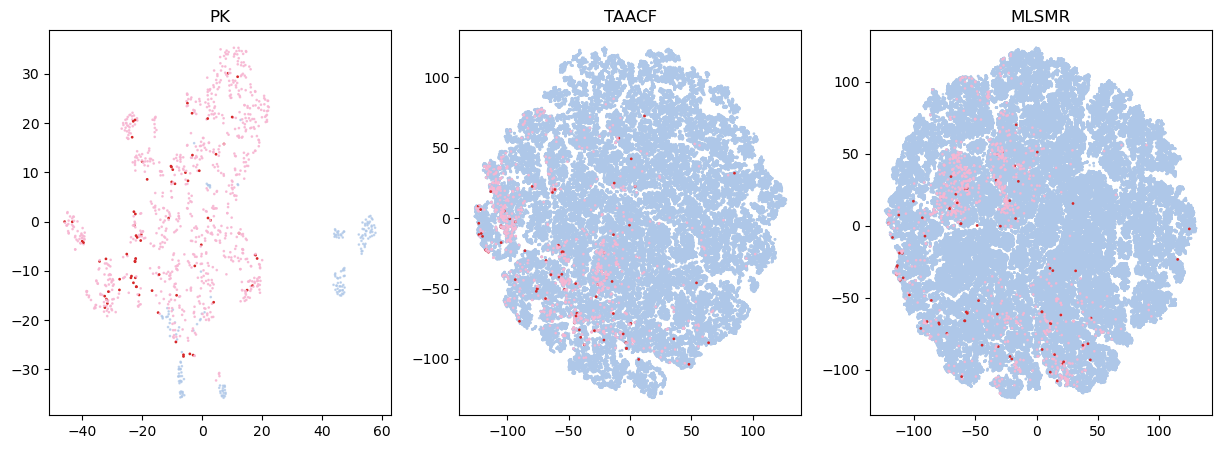

In [53]:
REDUCE_USING_PCA = True
N_PCA_COMPONENTS = 5

datasets = [
    ('PK', pk),
    ('TAACF', taacf),
    ('MLSMR', mlsmr)
]

def assign_colors(x):
    if x <= 2:
        return 0.05
    elif x == 4:
        return 0.65
    else:
        return 0.3
    
def assign_alpha(x):
    if x <= 2:
        return 0.7
    elif x == 4:
        return 0.85
    else:
        return 1.

fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(5*len(datasets), 5))

pca_artifacts = []
tsne_artifacts = []
pca_embeddings = []
tsne_embeddings = []

for i, (name, dataset) in enumerate(datasets):
    print(f"Processing {name} dataset...", end="")
    combined = pd.concat([dataset, enamine_top]).reset_index()
    fp_cols = [col for col in combined.columns if col.startswith('mfp')]
    X = combined[fp_cols]

    color = combined['split'].apply(assign_colors)
    alpha = combined['split'].apply(assign_alpha)
    sizes = color.apply(lambda x: 0.8 if x != 0.3 else 0.95)
    
    if REDUCE_USING_PCA:
        pca = PCA(n_components=N_PCA_COMPONENTS)
        X_pca = pca.fit_transform(X)
        pca_artifacts.append(pca)
        pca_embeddings.append(X_pca)

    tsne = TSNE()
    X_emb = tsne.fit_transform(X_pca)
    tsne_artifacts.append(tsne)
    tsne_embeddings.append(X_emb)

    axes[i].scatter(X_emb[:, 0], X_emb[:, 1], c=color, alpha=alpha, s=sizes, vmin=0., vmax=1., cmap='tab20')
    axes[i].set_title(f"{name}")
    print("Done.")

plt.show()

Processing PK dataset...Done.
Processing TAACF dataset...Done.
Processing MLSMR dataset...Done.


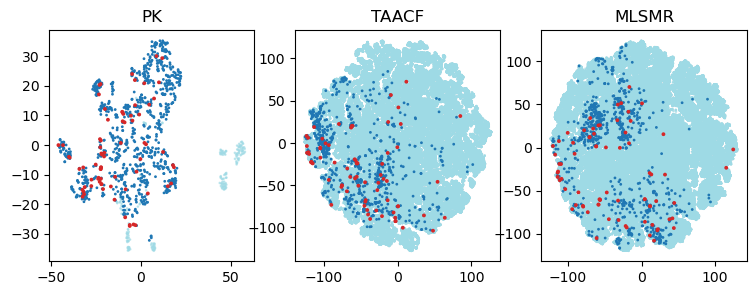

In [91]:
color_mapping = {'train': 0.95, 'predict': 0., 'select': 0.3}
opacity_mapping = {'train': 0.6, 'predict': 1., 'select': 1.}
marker_mapping = {'train': 'o', 'predict': 'o', 'select': 'o'}
size_mapping = {'train': 0.8, 'predict': 1., 'select': 3.}

height = 3

fig, axes = plt.subplots(nrows=1, 
                         ncols=len(datasets), 
                         figsize=(height*len(datasets), height))

for i, (name, dataset) in enumerate(datasets):
    print(f"Processing {name} dataset...", end="")
    combined = pd.concat([dataset, enamine_top]).reset_index()

    train_idx = combined[combined['split'] <= 2].index
    predict_idx = combined[combined['split'] == 4].index
    select_idx = combined[combined['split'] == 5].index

    indices = {'train': train_idx, 'predict': predict_idx, 'select': select_idx}

    X_emb = tsne_embeddings[i]

    for sample_set in ("train", "predict", "select"):
        x_set = X_emb[indices[sample_set], 0]
        y_set = X_emb[indices[sample_set], 1]

        axes[i].scatter(x_set,
                        y_set,
                        c=[color_mapping[sample_set]]*x_set.shape[0], 
                        alpha=opacity_mapping[sample_set], 
                        s=size_mapping[sample_set], 
                        marker=marker_mapping[sample_set],
                        vmin=0., vmax=1., 
                        cmap='tab20')

    axes[i].set_title(f"{name}")
    print("Done.")


In [54]:
with open("../data/archive/pca_artifacts.pkl", "wb") as f:
    pickle.dump(pca_artifacts, f)

with open("../data/archive/tsne_artifacts.pkl", "wb") as f:
    pickle.dump(tsne_artifacts, f)

with open("../data/archive/pca_embeddings.pkl", "wb") as f:
    pickle.dump(pca_embeddings, f)

with open("../data/archive/tsne_embeddings.pkl", "wb") as f:
    pickle.dump(tsne_embeddings, f)

In [120]:
def adversarial_validation(df_a, df_b, k=5, scoring='roc_auc', random_state=42):
    X_a = df_a[[col for col in df_a.columns if col.startswith('mfp')]]
    X_b = df_b[[col for col in df_b.columns if col.startswith('mfp')]]

    y_a = [0 for _ in range(X_a.shape[0])]
    y_b = [1 for _ in range(X_b.shape[0])]

    X_combined = pd.concat([X_a, X_b]).reset_index(drop=True)
    y_combined = np.concatenate([y_a, y_b])

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

    return cross_validate(XGBClassifier(), X_combined, y_combined, cv=skf, scoring=scoring, n_jobs=-1)

In [121]:
cv_pk = adversarial_validation(pk, enamine_top)
cv_taacf = adversarial_validation(taacf, enamine_top)
cv_mlsmr = adversarial_validation(mlsmr, enamine_top)

In [129]:
print_res = \
    lambda cv, name: print(f"{name}: {round(cv['test_score'].mean(), 3)} +/- {round(sem(cv['test_score'])*t.ppf((1 + 0.95) / 2., 4), 3)}")

In [131]:
print_res(cv_pk, "pk")
print_res(cv_taacf, "taacf")
print_res(cv_mlsmr, "mlsmr")

pk: 0.994 +/- 0.009
taacf: 0.995 +/- 0.002
mlsmr: 0.995 +/- 0.002
